In [2]:
! pip install torch torch-vision gym matplotlib numpy tqdm imageio
! pip install pygame atari_py graphviz gym-tetris pandas

In [0]:
# Instruct matplotlib to draw inline
import matplotlib.pyplot as plt
import imageio
import pdb
%matplotlib inline

# Ploting the train loss   
def plotloss(vloss, ploss, rewards):
    #x = np.linspace(0, 2, 100)
    x = range(len(rewards))
    #print (len(rewards), len(vloss))
    #plt.plot(x, vloss, label='Value loss')
    #plt.plot(x, ploss, label='Policy loss')
    #pdb.set_trace()
    plt.plot(x, rewards, label='Rewards')

    plt.xlabel('Epoch')
    plt.ylabel('Reward')

    plt.title("Average Rewards per Epoch")

    plt.legend()

    plt.show()    
    

def make_gif(rollout, filename):
    with imageio.get_writer(filename, mode='I', duration=1 / 30) as writer:
        for x in rollout:
          writer.append_data((x[0][:, :, 0] * 255).astype(np.uint8))    

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import gym
import gym_tetris
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
from queue import Queue
from threading import Thread
from itertools import chain

# device=torch.device('cpu')
      
# Combining the actor critic in same class
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.actor = nn.Sequential(
        nn.Linear(state_size, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, action_size)
        )
        # self.dist = Categorical(action_size, action_size)
        
    def forward(self, obs):
        x = self.actor(obs)
        
        prob = F.log_softmax(x, dim=1)
        # prob = F.softmax(x, dim=1)
        # dist = self.dist(prob)
        # action = dist.sample()
        
        self.dist = Categorical(logits=prob)
        action = self.dist.sample()              
        return prob, action     

class Critic(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    self.critic = nn.Sequential(
      nn.Linear(state_size, 10),
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10, 1)
      )
    
  def forward(self, obs):
    value = self.critic(obs)
    return value

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [0]:
class ExperienceDataset(Dataset):
    def __init__(self, experience):
        super(ExperienceDataset, self).__init__()
        self._exp = []
        for x in experience:
            self._exp.extend(x)
        self._length = len(self._exp)

    def __getitem__(self, index):
        return self._exp[index]

    def __len__(self):
        return self._length
      
def state_returns(states, gamma):
    curr_return = 0
    for i in reversed(range(len(states))):
        state, dist, action, reward = states[i]
        ret = reward + gamma * curr_return
        states[i] = (state, dist, action, reward, ret)
        curr_return = ret
    return states
      

def collect_episodes(envname, actor, num_rollouts, max_eplen, gamma):
  episodes = []
  rewards = []
  # just to eval the model
  actor.eval()
  env = gym.make(envname)
  for _ in range(num_rollouts):
    episode = []
    # env = gym.make(envname)
    initial_state = env.reset()
    total_reward = 0
    for _ in range(max_eplen):
      # Convert the environment state to pytorch tensor
      initial_state_tensor = fromnp(initial_state, device)
      # Pass the tensor to Actor Critic NN to get the distribution overaction
      # and best action to apply
      dist, action = actor(initial_state_tensor)
      # dist, action = dist[0], action[0]
      # Use the action from the NN to go to next state
      state, reward, done, info = env.step(action.item())
      # Add the state, distribution, action and reward to the list
      episode.append((initial_state, dist.cpu().detach().numpy(), action.detach(), reward))
      # episode.append((initial_state, dist.cpu().detach().numpy(), action, reward))
      total_reward += reward
      if done:
        break
      initial_state = state
    episode = state_returns(episode, gamma)
    episodes.append(episode)
    rewards.append(total_reward)
  return (episodes, rewards)
        
def fromnp(data, device):
    return torch.from_numpy(data).float().unsqueeze(0).to(device)

def tensorbatch(tensor, device):
    return tensor.detach().float().to(device)   
  
def multinomial_likelihood(dist, idx):
    return dist[range(dist.shape[0]), idx.long()[:, 0]].unsqueeze(1) 

#def multinomial_likelihood(dist, idx):
#    return dist[:, idx.long()[:, 0]].unsqueeze(1) 

In [0]:
# For parallel execution
#from joblib import Parallel, delayed 
#from multiprocessing import Pool

def algo(envs, actor, critic, epochs=50, episodeperenv=200, max_episode_len=200, discount=0.99, batch_size=128, epsilon=0.2, device=torch.device('cpu'), lr=1e-3):
  # Set up optimizer and loss function
  params = chain(actor.parameters(), critic.parameters())
  optimizer = optim.Adam(params, lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
  value_loss = nn.MSELoss()
  # Gif
  # gif_epoch = 5
  # Upper and lower bound for ppo
  ppo_lb = 1 - epsilon
  ppo_ub = 1 + epsilon
  
  # Progress bar
  loop = tqdm(total=epochs, position=0, leave=False)
  
  vloss = []
  ploss = []
  rewardslist = []
  
  for epoch in range(epochs):    
    # Collect experiences
    episodes, rewards = collect_episodes(
        envs, actor, episodeperenv, max_episode_len, discount)    
    # print (len(rewards), rewards)
    avgreward = sum(rewards) / len(rewards)
    # print (avgreward.shape)
    # Update time
    experience_dataset = ExperienceDataset(episodes)
    data_loader = DataLoader(experience_dataset, num_workers=0, batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=True)
    avg_policy_loss = 0
    avg_val_loss = 0   

    for _ in range(5):
      avg_policy_loss = 0
      avg_val_loss = 0
      for state, dist, old_action, reward, ret in data_loader:
        #print (state.shape, dist.shape, old_action.shape, reward.shape, ret.shape)
        tensor_state = tensorbatch(state, device)
        old_dist = tensorbatch(dist, device).squeeze()
        old_action = tensorbatch(old_action, device)
        ret = tensorbatch(ret, device).unsqueeze(1)
        
        # ratio  or important sampling
        curr_prob, _ = actor(tensor_state)
        # print (act.shape)
        #curr_prob = Categorical(logits=curr_dist).log_prob(old_action)
        #old_prob = Categorical(logits=old_dist).log_prob(old_action)
        # print (curr_dist.shape, old_dist.shape, old_action.shape)
        
        curr_prob = multinomial_likelihood(curr_prob, old_action)
        old_prob = multinomial_likelihood(old_dist, old_action)
        
        # ratio = (curr_prob / old_prob)       
        ratio = torch.exp(curr_prob - old_prob)
        #print ('ratio', ratio)
        
        exp_ret = critic(tensor_state)
        # Value loss
        val_loss =  value_loss(exp_ret, ret)
        
        # Policy loss from the paper
        adv = ret - exp_ret.detach()
        # adv = (adv - adv.mean()) / (adv.std() + 1e-5)
        lhs = ratio * adv
        # Clip
        rhs = torch.clamp(ratio, ppo_lb, ppo_ub) * adv
        policy_loss = -torch.mean(torch.min(lhs, rhs))
        
        # Losses
        avg_val_loss += val_loss.item()
        avg_policy_loss += policy_loss.item()
        
        # Learning
        totloss = policy_loss + val_loss
        
        optimizer.zero_grad()
        totloss.backward()
        # torch.nn.utils.clip_grad_norm(params, 10)
        # Take a step
        optimizer.step()
        
        # Log info
      avg_val_loss /= len(data_loader)
      avg_policy_loss /= len(data_loader)
    loop.set_description(
      'avg reward: % 6.2f, value loss: % 6.2f, policy loss: % 6.2f' % (avgreward, avg_val_loss, avg_policy_loss))      
      
    loop.update(1)
    vloss.append(avg_val_loss)
    ploss.append(avg_policy_loss)
    rewardslist.append(avgreward)

  
  return vloss, ploss, rewardslist

## Cartpole environment

In [0]:
def run(proc):
  envs = []
  for i in range(proc):
    env = gym.make('CartPole-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    envs.append(env)    
  actor = Actor(state_size, action_size)
  critic = Critic(state_size, action_size)
  #ac.cuda()
  vloss, ploss, rewards = algo('CartPole-v0', actor, critic)
  plotloss(vloss, ploss, rewards)    
  

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
avg reward:  198.93, value loss:  232.04, policy loss:   0.02: 100%|██████████| 50/50 [17:39<00:00, 23.16s/it]

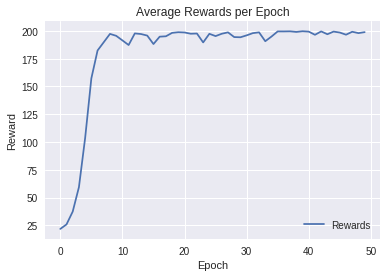

In [0]:
run(2)

## Breakout

In [0]:
device=torch.device('cuda')

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.float32)

def preprocess(img):
    return to_grayscale(img)
  
class GameWrapper():
  def __init__(self, name='BreakoutDeterministic-v4', history=5):
    super(GameWrapper, self).__init__()
    self.env = gym.make(name)
    self.res = (210, 160)
    self.history = history
    self.states = np.zeros((self.res[0], self.res[1], history), dtype=np.float32)
    
  def step(self, a):
    s,r,d,i = self.env.step(a)
    self.process(s)
    return self.states, r, d, i
  
  def reset(self):
    self.states = np.zeros((self.res[0], self.res[1], self.history), dtype=np.float32)
    s = self.env.reset()
    #print (self.env.reset().shape)
    self.process(s)
    return self.states
  
  def process(self, s):
    self.states = np.roll(self.states, 1, axis=2)
    self.states[:,:,0] = preprocess(s)
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input image: [n, 3, 430, 330]
        # Input image :[n, 3, 210, 160]
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 16, 2, stride=2),  
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 32, 2, stride=2),  
            nn.ReLU()
            #nn.Conv2d(32, 64, 3, padding=1),  
            #nn.ReLU(),
            #nn.Conv2d(64, 128, 2, stride=2), # 128*26*20
            #nn.ReLU()
            #nn.Conv2d(128, 128, 2, stride=2),
            #nn.ReLU(),
            #nn.Conv2d(128, 128, 2, stride=2) #128, 6, 5 ##128, 13, 10
        )

    def forward(self, x):
        x = x.permute((0, 3, 1, 2))
        #print('states', x.shape)
        states = self.conv(x)
        #print ('after state shape', states.shape)
        return states.view((-1, 128 * 26 * 20))
      
      
# Combining the actor critic in same class
class ActorTetris(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.actor = nn.Sequential(
        nn.Linear(128 * 26 * 20, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, action_size)
        )
        # self.dist = Categorical(action_size, action_size)
        
    def forward(self, obs):
        x = self.actor(obs)
        
        prob = F.log_softmax(x, dim=1)
        # prob = F.softmax(x, dim=1)
        # dist = self.dist(prob)
        # action = dist.sample()
        
        self.dist = Categorical(logits=prob)
        action = self.dist.sample()              
        return prob, action   

      
class CriticTetris(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    self.critic = nn.Sequential(
      nn.Linear(128 * 26 * 20, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 1)
      )
    
  def forward(self, obs):
    value = self.critic(obs)
    return value
          
def fromnp(data, device):
    return torch.from_numpy(data).float().unsqueeze(0).to(device)

def tensorbatch(tensor, device):
    return tensor.detach().float().to(device)   
  
def multinomial_likelihood(dist, idx):
    return dist[range(dist.shape[0]), idx.long()[:, 0]].unsqueeze(1)   

def collect_episodes_tetris(envname, actor, cnn, num_rollouts, max_eplen, gamma):
  episodes = []
  rewards = []
  # just to eval the model
  actor.eval()
  cnn.eval()
  # env = gym.make(envname)
  # 
  
  from gym import wrappers
  # env = wrappers.Monitor(env.env, '/tmp/',video_callable=False, force=True )
  
  for _ in range(num_rollouts):
    episode = []
    # env = gym.make(envname)
    env = GameWrapper(envname)
    initial_state = env.reset()
    total_reward = 0
    for _ in range(max_eplen):
      # Convert the environment state to pytorch tensor
      initial_state_tensor = fromnp(initial_state, device)
      # Pass the state from the environment to CNN
      initial_state_tensor = cnn(initial_state_tensor)
      # Pass the tensor to Actor Critic NN to get the distribution overaction
      # and best action to apply
      dist, action = actor(initial_state_tensor)
      # dist, action = dist[0], action[0]
      # Use the action from the NN to go to next state
      # print (action.item())
      state, reward, done, info = env.step(action.item())
      # Add the state, distribution, action and reward to the list
      episode.append((initial_state, dist.cpu().detach().numpy(), action.detach(), reward))
      # episode.append((initial_state, dist.cpu().detach().numpy(), action, reward))
      total_reward += reward
      # print ('rewards', reward, total_reward)
      if done:
        break
      initial_state = state
      
    # env.close()
    episode = state_returns(episode, gamma)
    episodes.append(episode)
    rewards.append(total_reward)
    #exp_q.put(episode)
    #reward_q.put(total_reward)
  return (episodes, rewards)  


def algo_tetris(envs, actor, critic, cnn=None, epochs=600, episodeperenv=15, max_episode_len=400, discount=0.99, batch_size=128, epsilon=0.2, device=torch.device('cpu'), lr=1e-3):
  # Set up optimizer and loss function
  params = chain(actor.parameters(), critic.parameters(), cnn.parameters())
  optimizer = optim.Adam(params, lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
  value_loss = nn.MSELoss(reduction='sum')
  # Gif
  # gif_epoch = 5
  # Upper and lower bound for ppo
  ppo_lb = 1 - epsilon
  ppo_ub = 1 + epsilon
  
  # Progress bar
  loop = tqdm(total=epochs, position=0, leave=False)
  statsfile = 'final.csv'
  with open(statsfile, 'w') as f:
    f.write('avgreward')
    
  vloss = []
  ploss = []
  rewardslist = []
  #import torch.multiprocessing as mp
  #cnn.share_memory()
  #actor.share_memory()
  for epoch in range(epochs):    
    # Collect experiences    
    #pool = Pool(processes=16)
    #results = [pool.apply_async(collect_episodes_tetris, args=(
    #    envs, actor, cnn, episodeperenv, max_episode_len, discount)
    #                           ) for i in range(16)]
    #output = [p.get() for p in results]
    #episodes, rewards = zip(*output)
    #processes = []
    #for p in range(16):
    #  proc = mp.Process(target=collect_episodes_tetris, args=(envs, actor, cnn, episodeperenv, max_episode_len, discount))
    #  proc.start()
    #  processes.append(proc)
      
    #for p in processes:
    #  p.join()
    #exp_q = Queue()
    #reward_q= Queue()
    #threads = [Thread(target=collect_episodes_tetris, args=(
    #    envs, actor, cnn, episodeperenv, max_episode_len, discount, exp_q, reward_q )) for i in range(4)]
    #for x in threads:
    #    x.start()
    #for x in threads:
    #    x.join()

    # Collect the experience
    # episodes = list(exp_q.queue)
    # avgreward = sum(reward_q.queue) / reward_q.qsize()      
    episodes, rewards = collect_episodes_tetris(
        envs, actor, cnn, episodeperenv, max_episode_len, discount)
    
    # print (len(rewards), rewards)
    avgreward = sum(rewards) / len(rewards)
    
    # print (avgreward.shape)
    # Update time
    experience_dataset = ExperienceDataset(episodes)
    data_loader = DataLoader(experience_dataset, num_workers=0, batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=False)
    avg_policy_loss = 0
    avg_val_loss = 0   
    if epoch == 0 :
      make_gif(episodes[0], 'breakout' + '%d.gif' % epoch)
    for _ in range(4):
      avg_policy_loss = 0
      avg_val_loss = 0
      for state, dist, old_action, reward, ret in data_loader:
        #print (state.shape, dist.shape, old_action.shape, reward.shape, ret.shape)
        tensor_state = tensorbatch(state, device)
        old_dist = tensorbatch(dist, device).squeeze()
        old_action = tensorbatch(old_action, device)
        ret = tensorbatch(ret, device).unsqueeze(1)
        
        optimizer.zero_grad()
        # Pass the state through the cnn
        # print (tensor_state.shape, type(tensor_state))
        tensor_state = cnn(tensor_state.cuda())
        
        # ratio  or important sampling
        curr_prob, _= actor(tensor_state.cuda())
        # print (act.shape)
        #curr_prob = Categorical(logits=curr_dist).log_prob(old_action)
        #old_prob = Categorical(logits=old_dist).log_prob(old_action)
        # print (curr_dist.shape, old_dist.shape, old_action.shape)
        try:
          curr_prob = multinomial_likelihood(curr_prob, old_action)
          old_prob = multinomial_likelihood(old_dist, old_action)
        except IndexError:
          break
        
        # ratio = (curr_prob.cuda() / old_prob.cuda())       
        ratio = torch.exp(curr_prob.cuda() - old_prob.cuda())
        #print ('ratio', ratio)
        
        exp_ret = critic(tensor_state.cuda())
        # Value loss
        # print ('return', exp_ret, ret)
        val_loss =  value_loss(exp_ret.cuda(), ret.cuda())
        
        # Policy loss from the paper
        # print (type(ret), type(exp_ret))
        adv = ret.cuda() - exp_ret.detach()
        # adv = (adv - adv.mean()) / (adv.std() + 1e-5)
        lhs = ratio * adv
        # Clip
        rhs = torch.clamp(ratio, ppo_lb, ppo_ub) * adv
        policy_loss = -torch.mean(torch.min(lhs, rhs))
        
        # Losses
        avg_val_loss += val_loss.item()
        avg_policy_loss += policy_loss.item()
        
        # Learning
        totloss = policy_loss + val_loss #+ entropy
        
        
        totloss.backward()
        # torch.nn.utils.clip_grad_norm(params, 10)
        # Take a step
        optimizer.step()
        
        # Log info
      avg_val_loss /= len(data_loader)
      avg_policy_loss /= len(data_loader)
    loop.set_description(
      'avg reward: % 6.2f, value loss: % 6.2f, policy loss: % 6.2f' % (avgreward, avg_val_loss, avg_policy_loss))      
    
    with open(statsfile, 'a+') as f:
      f.write('%6.2f\n' % (avgreward))
      
    loop.update(1)
    #vloss.append(avg_val_loss)
    #ploss.append(avg_policy_loss)
    rewardslist.append(avgreward)    
    make_gif(episodes[0], 'breakout' + '%d.gif' % epoch)
  #plotloss(vloss, ploss, rewardslist) 
  return vloss, ploss, rewardslist

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(210, 160, 4) 4
Discrete(4)


avg reward:   3.07, value loss:   5.17, policy loss:   0.00: 100%|██████████| 600/600 [7:38:11<00:00, 47.14s/it]

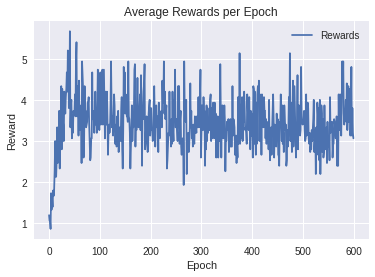

In [8]:
"""
  def run(proc):
  envs = gym_tetris.make('Tetris-v0')
  state_size = envs.observation_space.shape
  action_size = envs.action_space.n
  print (state_size, action_size)
  cnn = CNN()
  cnn = cnn.cuda()
  # rand = torch.empty((2, 430, 330, 3))
  # state = cnn(rand)
  
  actor = ActorTetris(state_size, action_size)
  critic = CriticTetris(state_size, action_size)
  actor = actor.cuda()
  critic = critic.cuda()
  vloss, ploss, rewards = algo_tetris('Tetris-v0', actor, critic, cnn)
  #plotloss(vloss, ploss, rewards)    
  #collect_experiences(envs, 16, ac)

run(2)
"""

def run(proc):
  envs = gym_tetris.make('BreakoutDeterministic-v4')
  #envs = gym_tetris.make('Breakout-v0')
  # state_size = envs.observation_space.shape
  state_size = (210, 160, 4)
  action_size = envs.action_space.n
  print (state_size, action_size)
  print (envs.action_space)
  
  cnn = CNN()
  cnn = cnn.cuda()
  # rand = torch.empty((2, 430, 330, 3))
  # state = cnn(rand)
  
  actor = ActorTetris(state_size, action_size)
  critic = CriticTetris(state_size, action_size)
  actor = actor.cuda()
  critic = critic.cuda()
  vloss, ploss, rewards = algo_tetris('BreakoutDeterministic-v4', actor, critic, cnn)
  plotloss(vloss, ploss, rewards)    

run(2)


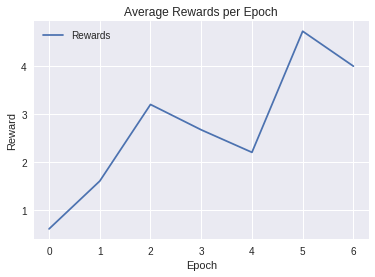

In [10]:
# Plot the results form the file is the run is stopped in the middle
import pandas as pd
data = pd.read_csv('final.csv', skipinitialspace=True)
plotloss(None, None, data) 

In [1]:
from google.colab import files
files.download('breakout40.gif') 
#!ls
#nvidia-smi

FileNotFoundError: ignored

# Breakout epoch 0
![sample output1](breakout0.gif)

## Acrobot

In [0]:
def run(proc):
  envs = []
  for i in range(proc):
    env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    envs.append(env)    
  actor = Actor(state_size, action_size)
  critic = Critic(state_size, action_size)
  #ac.cuda()
  vloss, ploss, rewards = algo('MountainCar-v0', actor, critic)
  plotloss(vloss, ploss, rewards)    
  #collect_experiences(envs, 16, ac)

run(2)

## Car Racing

In [0]:
def run(proc):
  envs = []
  for i in range(proc):
    env = gym.make('CarRacing-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    envs.append(env)    
  ac = ActorCritic(state_size, action_size)
  #ac.cuda()
  vloss, ploss, rewards = algo(envs, ac)
  plotloss(vloss, ploss, rewards)    
  #collect_experiences(envs, 16, ac)
  
run(16)  
  